このラボでは、Google Cloud Platform の AI Platform サービスで実行される Jupyter ノートブックをインスタンス化する方法について学習します。デモを進めるうえで、さまざまなフライト発着時間が含まれたデータセットを活用します。

## BigQuery クエリを実行する
このコマンドでは、マジック関数 %%bigquery を使用しています。ノートブックのマジック関数は、システム コマンドのエイリアスを提供します。ここでは、%%bigquery は BigQuery のセルでクエリを実行し、その出力を df という名前の Pandas DataFrame オブジェクトに格納しています。

In [1]:
%%bigquery df
SELECT
  departure_delay,
  COUNT(1) AS num_flights,
  APPROX_QUANTILES(arrival_delay, 10) AS arrival_delay_deciles
FROM
  `bigquery-samples.airline_ontime_data.flights`
GROUP BY
  departure_delay
HAVING
  num_flights > 100
ORDER BY
  departure_delay ASC

In [2]:
df.head()

,departure_delay,num_flights,arrival_delay_deciles
0,-37.0,107,"[-66.0, -44.0, -41.0, -35.0, -30.0, -23.0, -17..."
1,-36.0,139,"[-74.0, -43.0, -39.0, -37.0, -32.0, -25.0, -18..."
2,-35.0,191,"[-68.0, -45.0, -40.0, -36.0, -28.0, -19.0, -14..."
3,-34.0,195,"[-58.0, -44.0, -40.0, -35.0, -30.0, -25.0, -19..."
4,-33.0,227,"[-59.0, -43.0, -39.0, -36.0, -32.0, -28.0, -20..."


## Pandas を使用してプロットを作成する
クエリ出力が含まれる Pandas DataFrame を使用して、到着遅延が出発遅延にどのように関連しているかを示すプロットを作成します。
データが含まれる DataFrame を取得するには、まず未加工のクエリ出力を入手する必要があるため、arrival_delay_deciles のリストを Pandas の Series オブジェクトに変換します。コードを使用して、結果の列の名前を変更することもできます。Pandasに関してはこちらも参照ください。https://pandas.pydata.org/pandas-docs/stable/getting_started/10min.html

In [3]:
import pandas as pd

percentiles = df['arrival_delay_deciles'].apply(pd.Series)
percentiles.rename(columns = lambda x : '{0}%'.format(x*10), inplace=True)
percentiles.head()

,0%,10%,20%,30%,40%,50%,60%,70%,80%,90%,100%
0,-66.0,-44.0,-41.0,-35.0,-30.0,-23.0,-17.0,-12.0,-3.0,6.0,33.0
1,-74.0,-43.0,-39.0,-37.0,-32.0,-25.0,-18.0,-14.0,-7.0,2.0,49.0
2,-68.0,-45.0,-40.0,-36.0,-28.0,-19.0,-14.0,-8.0,-4.0,3.0,85.0
3,-58.0,-44.0,-40.0,-35.0,-30.0,-25.0,-19.0,-14.0,-8.0,2.0,39.0
4,-59.0,-43.0,-39.0,-36.0,-32.0,-28.0,-20.0,-14.0,-7.0,5.0,25.0


出発遅延時間と到着遅延時間を関連付けるため、percentiles テーブルを元の DataFrame の departure_delay フィールドに連結します。

In [4]:
df = pd.concat([df['departure_delay'], percentiles], axis=1)
df.head()

,departure_delay,0%,10%,20%,30%,40%,50%,60%,70%,80%,90%,100%
0,-37.0,-66.0,-44.0,-41.0,-35.0,-30.0,-23.0,-17.0,-12.0,-3.0,6.0,33.0
1,-36.0,-74.0,-43.0,-39.0,-37.0,-32.0,-25.0,-18.0,-14.0,-7.0,2.0,49.0
2,-35.0,-68.0,-45.0,-40.0,-36.0,-28.0,-19.0,-14.0,-8.0,-4.0,3.0,85.0
3,-34.0,-58.0,-44.0,-40.0,-35.0,-30.0,-25.0,-19.0,-14.0,-8.0,2.0,39.0
4,-33.0,-59.0,-43.0,-39.0,-36.0,-32.0,-28.0,-20.0,-14.0,-7.0,5.0,25.0


DataFrame の内容をプロットする前に、0% と 100% のフィールドに格納されている極端な値を削除します。

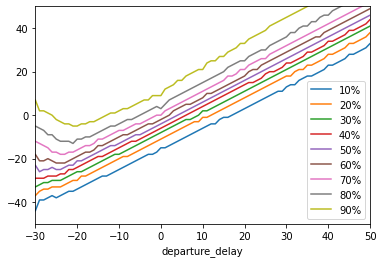

In [5]:
df.drop(labels=['0%', '100%'], axis=1, inplace=True)
df.plot(x='departure_delay', xlim=(-30,50), ylim=(-50,50));